# Rabbits and Foxes

I am running this in Python 2 at the moment becuause matplotlib is not working in my conda install of python 3.

# Euler's Method

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Initial conditions and values needed for the entire problem

k_1 = 0.015 # day^-1
k_2 = 0.00004 # day^-1 foxes^-1
k_3 = 0.0004 # day^-1 rabbits^-1
k_4 = 0.04 # day^-1

t_final = 600 # days
R_i = 400
F_i = 200


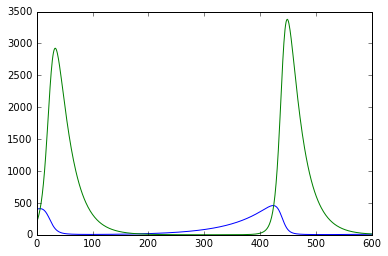

In [3]:
# Euler's method

i = 0
time = 0
del_t = 1 # The interval of time to change (days)
R = [] # A list of rabbit populations (number of rabbits)
F = [] # A list of fox populations (number of foxes)
t = [] # A list of corresponding times (days)

# Adding initial conditions to the corresponding lists
R.append(R_i)
F.append(F_i)
t.append(time)

# Performing Euler's method
while time < t_final:
    del_t = 1
    R.append(R[i] + del_t*(k_1 * R[i] - k_2 * R[i] * F[i]))
    F.append(F[i] + del_t*(k_3 * R[i] * F[i] - k_4 * F[i]))
    i += 1
    time += del_t
    t.append(time)

# Generate a plot of Euler's Method
plt.plot(t, R)
plt.plot(t, F)

# ODEINT Method

In [4]:
from scipy.integrate import odeint

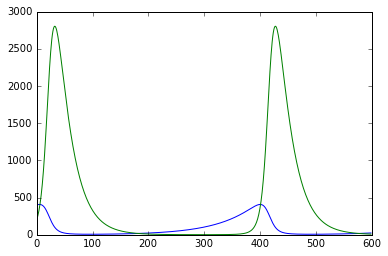

In [5]:
# odeint method

# Specify the initial conditions
population = [] # Will contain two lists, the first with the population of rabbits, the second with a population of foxes.
conditions = [R_i, F_i] # Initial conditions needed for `pop`. [population of rabbits, population of foxes]
t = np.array(range(t_final)) # Time array

def pop(cond, t):
    """
    A system of functions that describe the ordinary diff. eqs. for the rabbit and fox population.
    
    `y` is a list with the rabbit and fox population at time `t`.
    """
    R, F = cond
    del_R = k_1 * R - k_2 * R * F # Combined rate of rabbit population change.
    del_F = k_3 * R * F - k_4 * F # Combined rate of fox population change.
    return del_R, del_F

population = odeint(pop, conditions, t) # Performing odeint

# Defiing which list corresponds to rabbit and fox population.
R_pop = population[:,0] #Rabbit population (number of rabbits)
F_pop = population[:,1] #Fox population (number of foxes)


# Plot the results of the odeint method
plt.plot(t, R_pop)
plt.plot(t, F_pop)

# Kinetic Monte Carlo Method

In [6]:
"""
A series of functions to define the birth and / or death of a rabbit (R) or fox (F)
"""
import random
from math import log as ln
from scipy import signal
def R_birth(R,F):
    return k_1 * R
def R_death(R,F):
    return k_2 * R * F
def F_birth(R,F):
    return k_3 * R * F
def F_death(R,F):
    return k_4 * F

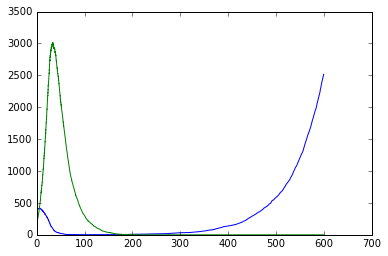

In [7]:
# kintetic Monte Carlo method

# Setting initial conditions
def kMC():
    
    t = 0
    rabbits = []
    foxes = []
    time = []
    Life = 0
    Death = 0

    rabbits.append(R_i)
    foxes.append(F_i)
    time.append(t)

    # Performng Monte Carlo Analysis
    while t < t_final:

        # Selecting the latest item in the rabbits and foxes list
        r = rabbits[-1]
        f = foxes[-1]

        # Determining the rates for each event.
        R_b = R_birth(r,f) 
        R_d = R_death(r,f)
        F_b = F_birth(r,f)
        F_d = F_death(r,f)

        # Cumulative function
        sum_rates = R_b + R_d + F_b + F_d 
        uQ = (1-random.random()) * sum_rates 

        # Determining which list to edit
        if uQ <= R_b:
            rabbits.append(r + 1)
            foxes.append(f)
        elif R_b < uQ <= R_b + R_d:
            rabbits.append(r - 1)
            foxes.append(f)
        elif R_b + R_d < uQ <= R_b + R_d + F_b:
            rabbits.append(r)
            foxes.append(f + 1)
        else:
            rabbits.append(r)
            foxes.append(f - 1)

        # Change in time according to KMC methods
        try:
            del_t = ln(1/(1-random.random())) / sum_rates
            t = t + del_t
            time.append(t)
        except:
            break #del_t has been breaking because of sum_rates = 0, if sum_rates = 0, the reaction has stopped.
        
    return time, foxes, rabbits
    
time, foxes, rabbits = kMC()
plt.plot(time, rabbits)
plt.plot(time, foxes)

Occasionally, the plot corresponding to the KMC method needs to be re-ran in order to attain a shape similar to the previous solutions.

What I need to determine:
- The time at which the second peak occurs
- The population at which the second peak occurs
- The average and interquartile range of these peaks (for both population and for time)
- The percentage of time that a second peak doesn't exist

In [8]:
# This portion is determing the time at which the second peak occurs, the population at the second peak for 100 trials.
# It also calculated the average population, time, and interquartile range for the foxes and time.
# Also, it determine how the foxes die
Deaths = 0
Lives = 0
fox_peak = [0]
corresponding_time = [0]
for i in range(100):
    time, foxes, rabbits = kMC()
    
    if foxes[-1] < 1:
        Deaths += 1
    else:
        edited_foxes = []
        Lives += 1
        for i in range(len(time)):
            if i < len(time) // 2:
                edited_foxes.append(0)
            else:
                x = foxes[i]
                edited_foxes.append(x)
        
        fox_peak.append(max(edited_foxes))
        corresponding_time.append(time[edited_foxes.index(max(edited_foxes))])

# Determining the average and interquartile range of the second peak of the fox population
average_foxes = sum(edited_foxes)/len(edited_foxes)
fox_iqr = np.subtract(*np.percentile(edited_foxes, [75, 25]))

# Determining the average and interquartile range of the time that the second peak of the fox population occurs at
average_time = sum(corresponding_time)/len(corresponding_time)
time_iqr = np.subtract(*np.percentile(corresponding_time, [75, 25]))

# Determining the percentage of time that the foxes die out before making it day 600.
total = Deaths + Lives
percentage = Deaths # because this was run over 100 iterations

# Report all the values
print "The average max number of foxes for the second peak is %i foxes. With an interquartile range of %i." % (average_foxes, fox_iqr)
print "The average time that the second fox peak occurs at is %0.2f days. With an interquartile range of %0.2f." % (average_time, time_iqr)
print "The fox population survives to day 600 %0.1f percent of the time." % (percentage)

The average max number of foxes for the second peak is 885 foxes. With an interquartile range of 1874.
The average time that the second fox peak occurs at is 391.20 days. With an interquartile range of 34.15.
The fox population survives to day 600 73.0 percent of the time.
